In [1]:
import os
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import geopandas as gp
import sklearn.preprocessing

# import pytesmo.scaling as scaling
# import pytesmo.metrics as metrics

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [2]:
# Read in the CSVs from the data folder

# find files
data_dir = "../data"
files = [os.path.join(data_dir,x) for x in os.listdir("../data") if x.endswith(".txt") or x.endswith(".csv")]

# read as dataframes
p = pd.read_csv(files[0])
q = pd.read_csv(files[1])
et = pd.read_csv(files[2])
ds = pd.read_csv(files[3], sep='\t', header=0)

# set indices as time
p.set_index(p.columns[0], inplace=True)
q.set_index(q.columns[0], inplace = True)
et.set_index(et.columns[0], inplace = True)

ds.set_index(ds['dt'], inplace = True)

# convert to datetime
ds.index = pd.to_datetime(ds.index)
p.index = pd.to_datetime(p.index)
q.index = pd.to_datetime(q.index)
et.index = pd.to_datetime(et.index)

# Change the ds index to be beginning of the month
ds.index += datetime.timedelta(days = 1)

# Merge the dfs
p_q = pd.merge(p,q, left_index=True, right_index=True)
p_q_et = pd.merge(p_q, et, left_index=True, right_index=True)

# Set the timezones to none
p_q_et = p_q_et.tz_localize(None).copy()
ds = ds.tz_localize(None).copy()

# Merge again
df = pd.merge(p_q_et, ds, left_index=True, right_index=True)

# Drop irrelevant columns
df.drop(["region", 'dt'], axis = 1, inplace = True)

In [3]:
df.head()

,trmm,prism,chirps,discharge_cms,modis,gldas,gridmet,s
2001-01-01,1.093282e+07,5.273174e+06,3.062379e+06,368.118400,1.773670e+06,4.593587e+05,1.174011e+06,4580.215098
2001-02-01,1.432065e+07,6.721928e+06,3.510050e+06,504.039040,1.534297e+06,6.572096e+05,1.345984e+06,4580.902281
2001-03-01,6.189033e+06,3.217688e+06,2.264511e+06,903.305920,2.761055e+06,1.421961e+06,2.199432e+06,4581.688633
2001-04-01,7.002581e+06,3.531893e+06,1.728371e+06,393.603520,2.159400e+06,1.913153e+06,2.520901e+06,4582.127895
2001-05-01,2.803792e+05,2.534074e+05,2.999343e+05,262.496736,2.787220e+06,2.552808e+06,2.110090e+06,4581.939481


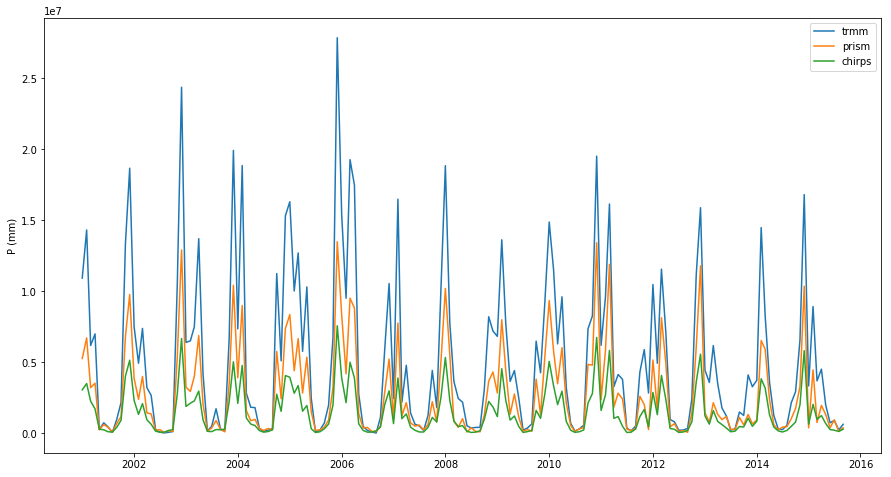

In [28]:
#Sanity check: plot

plt.figure(figsize = (15,8))

plt.plot(df.index,df.trmm, label = "trmm")
plt.plot(df.index,df.prism, label = "prism")
plt.plot(df.index,df.chirps, label = 'chirps')
plt.ylabel("P (mm)")
plt.legend()
plt.show()

## Triple collocation (Scipal, 2008):

Estimate the errors of each dataset as follows: 

### $$\sigma_{\varepsilon_x}^2 = \langle (x-y)(x-z) \rangle$$
### $$\sigma_{\varepsilon_y}^2 = \langle (y-x)(y-z) \rangle$$
### $$\sigma_{\varepsilon_z}^2 = \langle (z-x)(z-y) \rangle$$

where brackets denote temporal mean and X, Y, and Z are the three datasets

In [10]:
def calc_tc_error(x,y,z):
    e_x = np.sqrt(np.abs(np.mean((x - y) * (x - z))))
    e_y = np.sqrt(np.abs(np.mean((y - x) * (y - z))))
    e_z = np.sqrt(np.abs(np.mean((z - x) * (z - y))))

    return e_x, e_y, e_z

def scale_to_ref(src, ref):
    return ((src - np.mean(src)) /
            np.std(src)) * np.std(ref) + np.mean(ref)

In [23]:
# scale to prism as the reference

x = df.prism
y = df.trmm
z = df.chirps

y_scaled = scale_to_ref(y, x)
z_scaled = scale_to_ref(z, x)

e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)

print ("Reference Dataset: PRISM")
print ("Error of prism estimated: {}".format(round(e_x,3)))
print ("Error of trmm estimated: {}".format(round(e_y,3)))
print ("Error of chirps estimated: {}".format(round(e_z),3))

# plt.figure(figsize = (15,10))
# plt.plot(df.index, x, label='prism')
# plt.plot(df.index, y_scaled,label='trmm scaled to prism')
# plt.plot(df.index, z_scaled, label='chirps scaled to prism')
# plt.legend()
# plt.show()

Reference Dataset: PRISM
Error of prism estimated: 400337.978
Error of trmm estimated: 558636.063
Error of chirps estimated: 320035.0


In [24]:
# scale to trmm as the reference

x = df.trmm
y = df.prism
z = df.chirps

y_scaled = scale_to_ref(y, x)
z_scaled = scale_to_ref(z, x)

e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)

print ("Reference Dataset: TRMM")
print ("Error of trmm estimated: {}".format(round(e_x,3)))
print ("Error of prism estimated: {}".format(round(e_y,3)))
print ("Error of chirps estimated: {}".format(round(e_z),3))


# plt.figure(figsize = (15,10))
# plt.plot(df.index, x, label='prism')
# plt.plot(df.index, y_scaled,label='trmm scaled to prism')
# plt.plot(df.index, z_scaled, label='chirps scaled to prism')
# plt.legend()
# plt.show()

Error of trmm estimated: 1011927.999
Error of prism estimated: 725182.7
Error of chirps estimated: 579720.0


In [29]:
# scale to chirps as the reference

x = df.chirps
y = df.trmm
z = df.prism

y_scaled = scale_to_ref(y, x)
z_scaled = scale_to_ref(z, x)

e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)

print ("Reference Dataset: CHIRPS")
print ("Error of chirps estimated: {}".format(round(e_x,3)))
print ("Error of trmm estimated: {}".format(round(e_y,3)))
print ("Error of prism estimated: {}".format(round(e_z),3))

# plt.figure(figsize = (15,10))
# plt.plot(df.index, x, label='prism')
# plt.plot(df.index, y_scaled,label='trmm scaled to prism')
# plt.plot(df.index, z_scaled, label='chirps scaled to prism')
# plt.legend()
# plt.show()

Error of chirps estimated: 164196.905
Error of trmm estimated: 286613.227
Error of prism estimated: 205397.0


In [98]:
# All scaling / error combinations:

x = np.array(df.trmm)
y = np.array(df.prism)
z = np.array(df.chirps)

# Dict to loop through
data = {}

data['trmm'] = x
data['prism'] = y
data['chirps'] = z

# Dict to store error calculations 
errors = {}

errors['trmm'] = []
errors['prism'] = []
errors['chirps'] = []

for k,v in data.items():
    ref_key = k
    ref_vals = data[k]
    target_keys = [key for key, value in data.items() if k not in key.lower()] 
    target_vals = [value for key, value in data.items() if k not in key.lower()]
    
    y_scaled = scale_to_ref(target_vals[0], ref_vals)
    z_scaled = scale_to_ref(target_vals[1], ref_vals)
    
    ex_ey_ez = calc_tc_error(ref_vals, y_scaled, z_scaled)
    outkeys = [k] + target_keys
    
    for i, x in enumerate(outkeys):
        errors[outkeys[i]].append(ex_ey_ez[i])
    

In [105]:
trmm_uc = np.array(errors['trmm']).mean()
prism_uc = np.array(errors['prism']).mean() 
chirps_uc = np.array(errors['chirps']).mean()

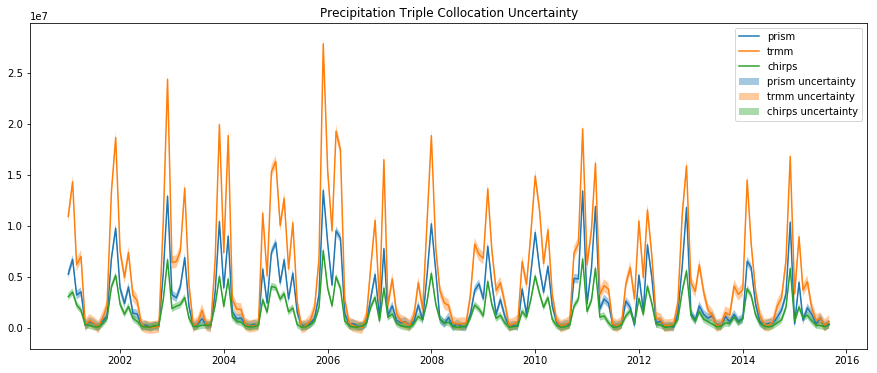

In [106]:
# Plot all uncertainties on one plot

plt.figure(figsize = (15,6))

plt.title("Precipitation Triple Collocation Uncertainty")

plt.plot(df.index, df.prism, label = "prism")
plt.fill_between(df.index, df.prism - prism_uc, df.prism + prism_uc, alpha = 0.4, label = "prism uncertainty")

plt.plot(df.index, df.trmm, label = "trmm")
plt.fill_between(df.index, df.trmm - trmm_uc, df.trmm + trmm_uc, alpha = 0.4, label = "trmm uncertainty")

plt.plot(df.index, df.chirps, label = 'chirps')
plt.fill_between(df.index, df.chirps - chirps_uc, df.chirps + chirps_uc, alpha = 0.4, label = "chirps uncertainty")

plt.legend()

plt.savefig("../figs/uncertainty_precip.png")

plt.show()

<Figure size 432x288 with 0 Axes>

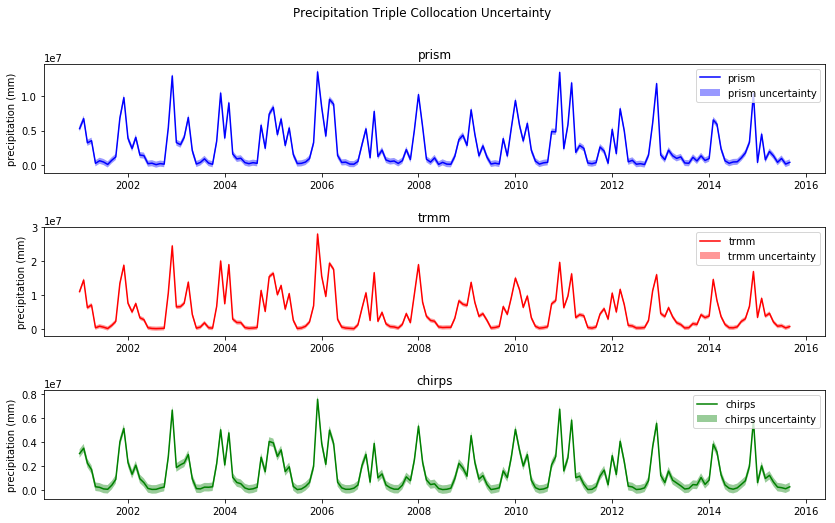

In [107]:
# Individual plots

plt.figure()

plt.subplots(nrows=3, ncols=1, figsize = (14,8))
          
plt.suptitle("Precipitation Triple Collocation Uncertainty")

plt.subplot(3,1,1)
plt.title("prism")
plt.plot(df.index, df.prism, label = "prism", c = "blue")
plt.fill_between(df.index, df.prism - prism_uc, df.prism + prism_uc, alpha = 0.4,facecolor = "blue", label = "prism uncertainty")
plt.ylabel("precipitation (mm)")
plt.legend()

plt.subplot(3,1,2)
plt.title("trmm")
plt.plot(df.index, df.trmm, label = "trmm", c = "red")
plt.fill_between(df.index, df.trmm - trmm_uc, df.trmm + trmm_uc, alpha = 0.4,facecolor = "red", label = "trmm uncertainty")
plt.ylabel("precipitation (mm)")
plt.legend()

plt.subplot(3,1,3)
plt.title("chirps")
plt.plot(df.index, df.chirps, label = 'chirps', c = "green")
plt.fill_between(df.index, df.chirps - chirps_uc, df.chirps + chirps_uc, alpha = 0.4, facecolor = "green", label = "chirps uncertainty")
plt.ylabel("precipitation (mm)")
plt.legend(loc = "upper right")

plt.subplots_adjust(hspace=.5)

# plt.savefig("../figs/uncertainty_precip.png")

plt.show()

# Water balance

In [108]:
# Get the area over which precip and ET were calculated over
hu4 = gp.read_file("../shape/cv_hu6.shp")
study_area = hu4.AreaSqKm.values
study_area = study_area * 1000000. # sq km to sq m

# Now convert to the appropriate units

df['q'] = df.discharge_cms*2.628e+6 # convert cms to cubic m/month
df['p'] = df.prism*study_area * 1e-3 # multiply by study area and convert mm to m
df['et_gridmet'] = df.gridmet*study_area * 1e-3 # multiply by study area and convert mm to m
df['et_modis'] = df.modis*study_area * 1e-3 # multiply by study area and convert mm to m
df['s_m3'] = df.s * 1.23348e+9 # convert from million acre ft to cubic m 

In [109]:
df['ds'] = df.p - df.et_gridmet - df.q

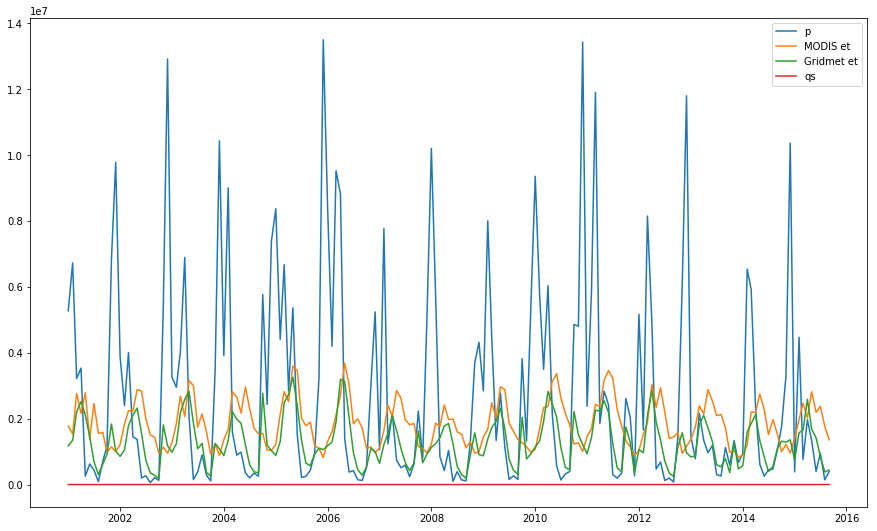

In [110]:
plt.figure(figsize = (15, 9))

plt.plot(df.index,df['prism'], label = "p")
plt.plot(df.index,df['modis'], label = "MODIS et")
plt.plot(df.index,df['gridmet'], label = "Gridmet et")
plt.plot(df.index,df['discharge_cms'], label = "qs")

plt.legend()
plt.show()

In [111]:
# Compute annual ds sums from ds = P - ET - Q:
years = np.arange(df.index[0].year, df.index[-1].year+1)

sums = {}

for year in years:
    year_df = df[df.index.year == year]
    year_sum = np.sum(year_df['ds'])
    sums[year] = year_sum
    

In [112]:
# Compute annual ds sums from ds = P - ET - Q:
years = np.arange(df.index[0].year, df.index[-1].year-1)

rs_sums = {}
c2v_sums = {}

startmonth = 11

for year in years:

    # Select df for nov and the first year
    ydf1 = df.iloc[df.index.year == year]
    mdf1 = ydf1.iloc[ydf1.index.month == startmonth]
    
    # advance a year and select df
    nextyear_df = df.iloc[df.index.year == year+1]
    nextmonth_df = nextyear_df.iloc[nextyear_df.index.month == startmonth-1]
    
    # subset original df based on start and end indices
    hydro_year_df = df.loc[mdf1.index[0] : nextmonth_df.index[0]]
    
    # compute the sums
    c2v_sums[year] = hydro_year_df['s_m3'][-1] - hydro_year_df['s_m3'][0]
    rs_sums[year] = hydro_year_df['ds'].sum()
    

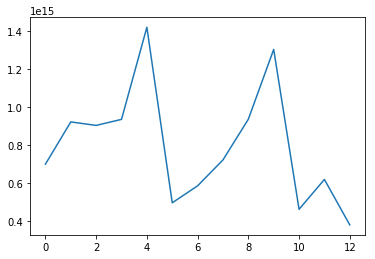

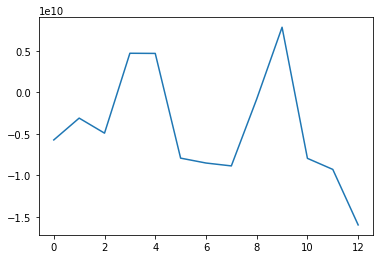

In [113]:
plt.plot(rs_sums.values())
plt.show()
plt.plot(c2v_sums.values())
plt.show()

In [114]:
dt_idx = pd.date_range(start=df.index[0], end=df.index[-1] + relativedelta(years=1),  freq='Y')
ds_df = pd.DataFrame({'ds':list(rs_sums.values()), 'c2vds': list(c2v_sums.values())})

ds_df.head()

,ds,c2vds
0,6.996831e+14,-5.718579e+09
1,9.226490e+14,-3.089006e+09
2,9.042496e+14,-4.900562e+09
3,9.360441e+14,4.726428e+09
4,1.422262e+15,4.707250e+09


# Scaling: 
## $ X_{scaled} = \frac{X_i - \mu}{\sigma_x}$

In [115]:
mms = sklearn.preprocessing.StandardScaler()

scaled = []

for i in [ds_df['ds'],ds_df['c2vds'],df['s_m3']]:
    i = i[~np.isnan(i)]
    j = np.array(i).reshape(-1,1)
    out = mms.fit_transform(j)
    scaled.append(out)


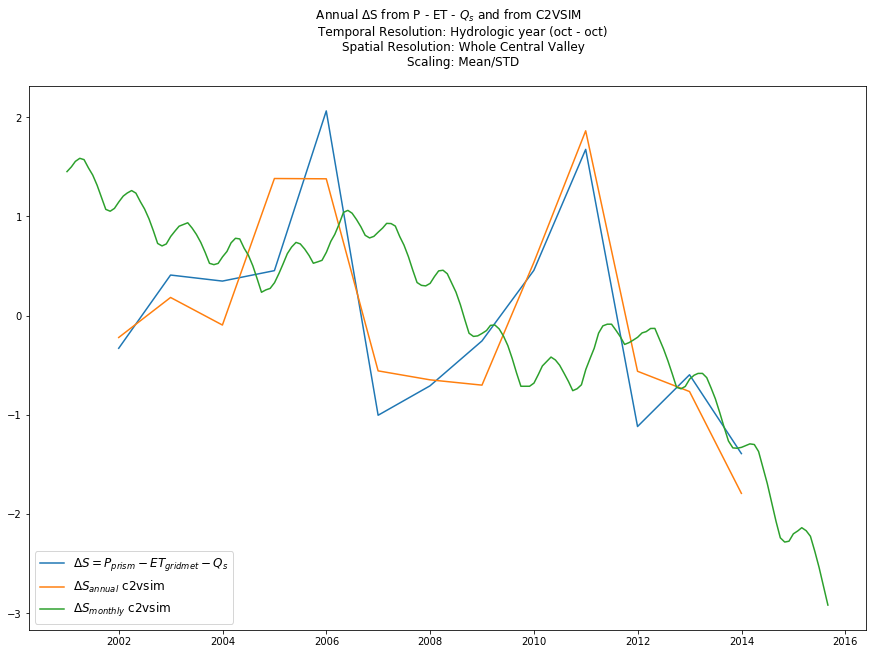

In [116]:
plt.figure(figsize=(15,10))

plt.title(
    """ Annual $\Delta$S from P - ET - $Q_s$ and from C2VSIM
        Temporal Resolution: Hydrologic year (oct - oct)
        Spatial Resolution: Whole Central Valley
        Scaling: Mean/STD
    """)

plt.plot(dt_idx[:-2], scaled[0], label = "$\Delta S = P_{prism} - ET_{gridmet} - Q_{s}$")

plt.plot(dt_idx[:-2], scaled[1], label = "$\Delta S_{annual}$ c2vsim")

plt.plot(df.index, scaled[2], label = "$\Delta S_{monthly}$ c2vsim")

# plt.savefig("../figs/hydro_year_balance.png")

plt.legend(loc="lower left", fontsize = 'large')

plt.show()

# Inverse transform the scaled data

In [15]:
inverted = []
for i in scaled:
    inverted.append(mms.inverse_transform(i))

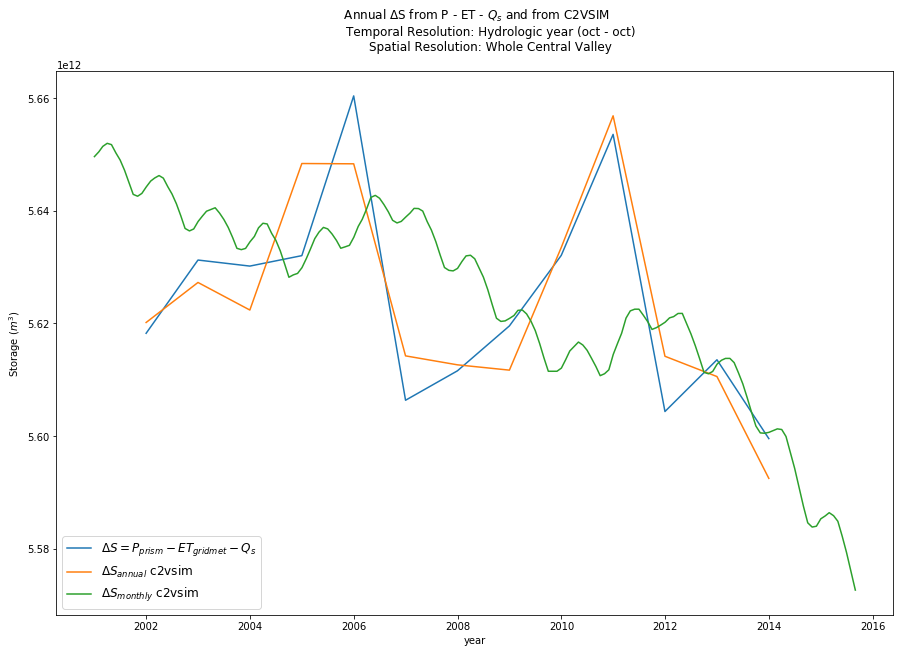

In [21]:
plt.figure(figsize=(15,10))

plt.title(
    """ Annual $\Delta$S from P - ET - $Q_s$ and from C2VSIM
        Temporal Resolution: Hydrologic year (oct - oct)
        Spatial Resolution: Whole Central Valley
    """)

plt.plot(dt_idx[:-2], inverted[0], label = "$\Delta S = P_{prism} - ET_{gridmet} - Q_{s}$")

plt.plot(dt_idx[:-2], inverted[1], label = "$\Delta S_{annual}$ c2vsim")

plt.plot(df.index, inverted[2], label = "$\Delta S_{monthly}$ c2vsim")

plt.legend(loc="lower left", fontsize = 'large')
plt.ylabel("Storage $(m^{3})$")
plt.xlabel("year")

plt.savefig("../figs/hydro_year_balance_absolute.png")

plt.show()